#### 题目3

In [5]:
import numpy as np
import random as random



In [2]:
def Starttime():    
    u=random.uniform(0,1.001)
    while(u>1):
        u=random.uniform(0,1.001)
    if u<=0.1:
        return -15
    elif u<=0.35:
        return -5
    elif u<=0.85:
        return 0
    elif u<=0.95:
        return 10
    else:
        return 15
def Servicetime():
    u=random.uniform(0,1.001)
    while(u>1):
        u=random.uniform(0,1.001)
    if u<=0.1:
        return 24
    elif u<=0.3:
        return 27
    elif u<=0.7:
        return 30
    elif u<=0.85:
        return 33
    elif u<=0.95:
        return 36
    else:
        return 39

In [3]:
class service():
    def __init__(self,stoptime) -> None:
        self.starttime=Starttime()#病人预计到达时间
        self.servicetime=Servicetime()#预计服务时间
        self.laststoptime=stoptime#上次接诊什么时候结束
        self.nextstoptime=self.Time_calculate()-30#本次接诊超时几分钟
    def Time_calculate(self):
        if self.starttime<=self.laststoptime:
            return self.servicetime
        else:
            return self.servicetime+self.starttime-self.laststoptime
def nextservice(lastservice:service):
    nextserviceevent=service(lastservice.nextstoptime)
    return nextserviceevent

In [4]:
def day():
    nextservice0=service(0)
    for t in range(15):
        nextservice0=nextservice(nextservice0)
    return nextservice0.nextstoptime+30*16
def simulate(time):
    Timeall=0
    for t in range(time):
        Timeall+=day()
    print(Timeall/time)
    return Timeall/time

In [5]:
timesimulate=simulate(10000)

482.35


题目6

利用Simpy进行模拟


可能出现的情况：
 1. 全部空
 2. 部分空
 3. 没空

触发事件的条件
 柜台有空：
 1. 顾客进入//更新柜台空余情况，服务时间
 2. 顾客离开//更新柜台空余情况
   
 柜台没空：
 1. 顾客进入//更新队列人数，
 2. 顾客离开//更新队列人数，更新服务时间

In [2]:
import simpy
env = simpy.Environment()


In [18]:
import simpy
import random
# 定义银行模拟函数
def credit_card_service(env, num_cashiers, arrival_rate):
    # 创建环境
    cashiers = simpy.Resource(env, num_cashiers)
    total_waiting_time = 0
    busy_time = [0]*4
    customer_count = 0
    customer_quit = 0
    servicetimeall=0
    # 定义客户等待函数
    def customer_wait(currentCustom: int):# 包括正在服务的
        randomInt = random.randint(1,100)
        if currentCustom < 6:
            return True
        elif currentCustom <= 8:
            return randomInt <= 80
        elif currentCustom <= 10:
            return randomInt <= 60
        elif currentCustom <= 14:
            return randomInt <= 40
        else:
            return randomInt <= 20

    # 定义客户到达函数
    def customer_arrival():
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            nonlocal customer_count
            customer_count += 1
            env.process(customer_service(env, cashiers, env.now))
    
    # 定义客户服务函数
    def customer_service(env, cashiers, arrival_time):
        currentCustom = len(cashiers.queue)
        if (customer_wait(currentCustom) == False):
            nonlocal customer_quit
            customer_quit += 1
            return
        with cashiers.request() as request:
            yield request
            #cashier_id = cashiers.users.index(request.user)
            service_start_time = env.now
            service_time = random.uniform(3, 5)
            nonlocal servicetimeall
            servicetimeall+=service_time
            yield env.timeout(service_time)
            #nonlocal busy_time
            #busy_time[cashier_id] += service_time
            waiting_time = service_start_time - arrival_time
            #print(f"前面的人数: {currentCustom:.2f}")
            #print(f"客户等待时间: {waiting_time:.2f} 分钟")
            nonlocal total_waiting_time
            total_waiting_time += waiting_time
    
    env.process(customer_arrival())
    
    # 开始模拟
    env.run(until=1440)  # 模拟1天，单位是分钟
    total_simulation_time = env.now
    average_waiting_time = total_waiting_time / customer_count
    print(f"客户平均等待时间: {average_waiting_time:.2f} 分钟")
    print(f"客户放弃概率: {customer_quit / customer_count:.2f}")
    print(f"出纳员空闲概率: {(1-servicetimeall/4/total_simulation_time):.2f}")

# 设置模拟参数
env = simpy.Environment()
num_cashiers = 4
arrival_rate = 1  # 平均每分钟1名到达

# 运行模拟
credit_card_service(env, num_cashiers, arrival_rate)

客户平均等待时间: 3.46 分钟
客户放弃概率: 0.05
出纳员空闲概率: 0.04


In [11]:
import simpy
import random
# 定义信用卡服务处模拟函数
def credit_card_service(env, num_cashiers, service_rate, arrival_rate):
    # 创建环境
    random.seed(42)
    cashiers = simpy.Resource(env, num_cashiers)
    busy_time = 0  # 记录出纳员的总工作时长
    total_waiting_time = 0
    customer_count = 0
    # 定义客户到达函数
    def customer_arrival():
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            nonlocal customer_count
            customer_count += 1
            env.process(customer_service(env, cashiers, service_rate, env.now))
    
    # 定义客户服务函数
    def customer_service(env, cashiers, service_rate, arrival_time):
        with cashiers.request() as request:
            yield request
            service_start_time = env.now
            service_time = random.expovariate(service_rate)
            yield env.timeout(service_time)
            nonlocal busy_time
            busy_time += service_time
            service_end_time = env.now
            waiting_time = service_start_time - arrival_time
            # print(f"客户等待时间: {waiting_time:.2f} 分钟")
            nonlocal total_waiting_time
            total_waiting_time += waiting_time
    
    env.process(customer_arrival())
    
    # 开始模拟
    env.run(until=1440)  # 模拟1天，单位是分钟
    total_simulation_time = env.now
    average_waiting_time = total_waiting_time / customer_count
    print(f"客户平均等待时间: {average_waiting_time:.2f} 分钟")
    busy_probability = busy_time / total_simulation_time / 4

    print(f"出纳员忙的概率: {busy_probability:.2%}")

# 设置模拟参数
env = simpy.Environment()
num_cashiers = 4
service_rate = 1 / 3  # 平均服务时间3分钟
arrival_rate = 1  # 平均每分钟1名学生到达

# 运行模拟
credit_card_service(env, num_cashiers, service_rate, arrival_rate)


客户平均等待时间: 1.67 分钟
出纳员忙的概率: 76.41%


#### 题目9

In [ ]:
env = simpy.Environment()
bcs = simpy.Resource(env, capacity=4) 
def car(env, name, bcs, driving_time, charge_duration):
    # Simulate driving to the BCS
    yield env.timeout(driving_time)
    # Request one of its charging spots
    print('%s arriving at %d' % (name, env.now))
    with bcs.request() as req:
        yield req
        # Charge the battery
        print('%s starting to charge at %s' % (name, env.now))
        yield env.timeout(charge_duration)
        print('%s leaving the bcs at %s' % (name, env.now))

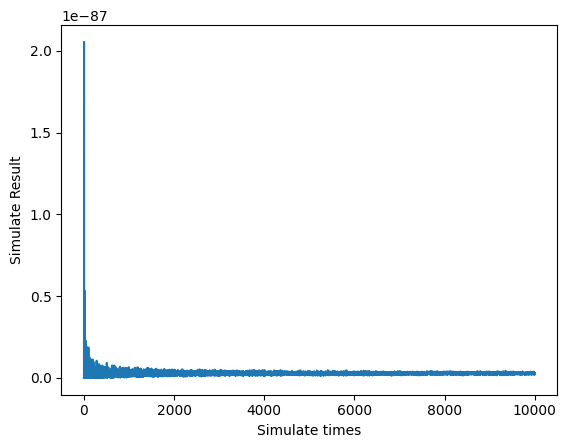

In [21]:
import random as random
import math as math
import numpy as np
import matplotlib.pyplot as plt
def simulate(number):
    if number ==0:
        return 0
    length=number
    sum=0
    for t in range(length):
        x=random.uniform(0,1/20)
        sum+=1/20/x/x/math.sqrt(2*math.pi)*math.exp(-1/2/x/x)
    result=sum/length
    return result
def simulate2(number):
    if number ==0:
        return 0
    length=number
    sum=0
    for t in range(length):
        x=random.uniform(0,1/20)
        sum+=1/20/x/x/math.sqrt(2*math.pi)*math.exp(-1/2/x/x)
    result=sum/length
    return result
x=[]
y=[]
z=[]
for t in range(10000):
    x.append(t)
    y.append(simulate(t))
    ax=np.array(x)
    ay=np.array(y)
    #print(t)
plt.plot(ax,ay)
plt.xlabel("Simulate times")
plt.ylabel("Simulate Result")
    
plt.show()


In [22]:
print(y[-1],y[-2],y[-3],y[-4])

2.8004510965873362e-89 2.3269485697305925e-89 3.1039854228698715e-89 2.5349881159066218e-89
